In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import math
import aesara.tensor as at
import seaborn as sb
import matplotlib
import pickle

In [2]:
train_data = pd.read_csv(
    "../data_acquisition/data_0.3/training_standardized.csv", sep=";"
)

features = np.swapaxes(
    np.array(
        [
            train_data["home_xG"],
            train_data["away_xg_against"],
            train_data["away_xG"],
            train_data["home_xg_against"],
            train_data["home_xT_all"],
            train_data["away_xt_all_against"],
            train_data["away_xT_all"],
            train_data["home_xt_all_against"],
        ]
    ),
    0,
    1,
)
form = np.swapaxes(
    np.array(
        [
            (train_data["ha_form_home_for"]),
            (train_data["ha_form_home_against"]),
            (train_data["ha_form_away_for"]),
            (train_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(
    np.array([train_data["home_score"], train_data["away_score"]]), 0, 1
)

elo_diff = np.swapaxes(
    np.array([(train_data["elo_diff_home"]), (train_data["elo_diff_away"])]), 0, 1
)

In [3]:
with pm.Model() as independent_poisson:
    pm_features = pm.Data("pm_features", features, mutable=True)
    pm_form_diff = pm.Data("pm_form_diff", form, mutable=True)
    pm_goals = pm.Data("pm_goals", goals, mutable=True)
    pm_elo_diff = pm.Data("pm_elo_diff", elo_diff, mutable=True)

    coefs_features = pm.Normal(
        "coefs_features",
        shape=(features.shape[1], 2),
    )

    coefs_elo_diff = pm.Normal(
        "coefs_elo_diff",
        shape=(elo_diff.shape[1], 2)
    )

    coefs_form_diff = pm.Normal(
        "coefs_form_diff", shape=(form.shape[1], 2)
    )  
    intercepts = pm.Normal("intercepts", shape=2)

    log_lam = pm.Deterministic(
        "log_lam",
        intercepts
        + (pm_elo_diff @ coefs_elo_diff)
        + (pm_form_diff @ coefs_form_diff)
        + (pm_features @ coefs_features),
    )


    lam = pm.math.exp(log_lam)

    obs = pm.Poisson("obs", mu=lam, observed=pm_goals)

In [4]:
N = train_data.shape[0]
K = 2
M = 10

with pm.Model() as dependent_normal_1:
    pm_features = pm.Data("pm_features", features, mutable=True)
    pm_form_diff = pm.Data("pm_form_diff", form, mutable=True)
    pm_goals = pm.Data("pm_goals", goals, mutable=True)
    pm_elo_diff = pm.Data("pm_elo_diff", elo_diff, mutable=True)

    cov_diag = pm.HalfNormal("cov_diag", shape=K)
    cov_root = pm.Normal("cov_root", shape=(M, K))
    cov = pm.Deterministic("cov", cov_root.T @ cov_root + at.diag(cov_diag))

    coefs_features = pm.HalfNormal(
        "coefs_features",  # mu=[[1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1]],
        sigma=[
            [1, 0.001],
            [1, 0.001],
            [0.001, 1],
            [0.001, 1],
            [1, 0.001],
            [1, 0.001],
            [0.001, 1],
            [0.001, 1],
        ],
        shape=(features.shape[1], 2),
    )

    coefs_elo_diff = pm.Normal(
        "coefs_elo_diff", mu=[0.5, -0.5], sigma=[0.2, 0.2], shape=(1, 2)
    )

    coefs_form_diff = pm.Normal(
        "coefs_form_diff", shape=(form.shape[1], 2)
    )
    factor = pm.Dirichlet("factor", a=np.ones(3))
    intercepts = pm.Normal("intercepts", shape=2)

    log_lam = pm.MvNormal(
        "log_lam",
        intercepts
        + 0.1 * (pm_elo_diff @ coefs_elo_diff)
        + 0.4 * (pm_form_diff @ coefs_form_diff)
        + 0.5 * (pm_features @ coefs_features),
        cov=cov,
        shape=(K),
    )

    lam = pm.math.exp(log_lam)

    obs = pm.Poisson("obs", mu=lam, observed=pm_goals)

In [5]:
with pm.Model() as dependent_normal_2:
    pm_features = pm.Data("pm_features", features, mutable=True)
    pm_form_diff = pm.Data("pm_form_diff", form, mutable=True)

    sd_dist = pm.HalfNormal.dist(shape=2)
    chol, corr, stds = pm.LKJCholeskyCov('chol_cov', n=2, eta=2, sd_dist=sd_dist, compute_corr=True)

    coefs = pm.Normal('coefs', shape=(features.shape[1], 2))
    coefs_form = pm.Normal('coefs_form', shape=(form.shape[1], 2))

    intercepts = pm.Normal('intercepts', shape=2)
    log_lam = pm.MvNormal('log_lam', mu=intercepts + (pm_features @ coefs) +
                                                     (pm_form_diff @ coefs_form), chol=chol, shape=(2))
    lam = pm.math.exp(log_lam)
    obs = pm.Poisson('obs', mu=lam, observed=goals)

In [6]:
MODEL = independent_poisson
# MODEL = dependent_normal_1
# MODEL = dependent_normal_2

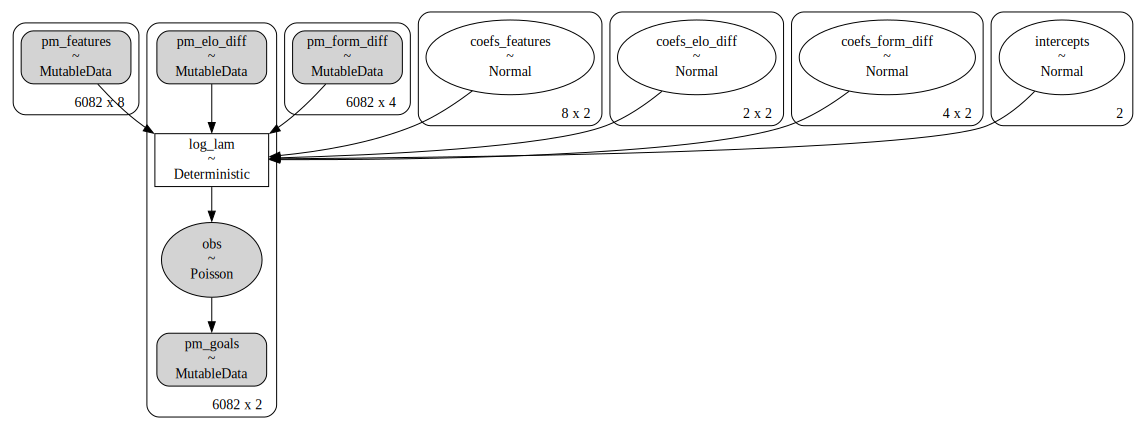

In [7]:
pm.model_to_graphviz(MODEL)

In [8]:
TRAIN_MODEL = False

In [9]:
if TRAIN_MODEL:
    with MODEL:
        app = pm.fit(50000, progressbar=True)
        trace = app.sample(1000)
        if False:
            trace.to_netcdf("models/independent_trace.nc")
else:
    trace = az.from_netcdf("models/independent_trace.nc").load()

# Test

In [10]:
test_data = pd.read_csv(
    "../data_acquisition/data_0.3/test_standardized.csv", sep=";"
).dropna()


test_data_orig_size = test_data.shape[0]
size_diff = train_data.shape[0] - test_data.shape[0]
column_size = test_data.shape[1]
fill_data = [np.ones(column_size) for _ in range(size_diff)]
test_data_fill = pd.DataFrame(data=fill_data, columns=test_data.columns)
test_data = pd.concat([test_data, test_data_fill])

features = np.swapaxes(
    np.array(
        [
            test_data["home_xG"],
            test_data["away_xg_against"],
            test_data["away_xG"],
            test_data["home_xg_against"],
            test_data["home_xT_all"],
            test_data["away_xT_all"],
            test_data["home_xt_all_against"],
            test_data["away_xt_all_against"],
        ]
    ),
    0,
    1,
)

form = np.swapaxes(
    np.array(
        [
            (test_data["ha_form_home_for"]),
            (test_data["ha_form_home_against"]),
            (test_data["ha_form_away_for"]),
            (test_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(np.array([test_data["home_score"], test_data["away_score"]]), 0, 1)

elo = np.swapaxes(
    np.array([(test_data["elo_diff_home"]), (test_data["elo_diff_away"])]), 0, 1
)

with MODEL:
    pm.set_data(
        {
            "pm_elo_diff": elo,
            "pm_features": features,
            "pm_form_diff": form,
        }
    )

    sample_res = pm.sample_posterior_predictive(trace, predictions=True)
    predictions = sample_res["predictions"]

In [11]:
# save / load preditions:
# with open("models/predictions.pck", 'wb') as outp:
#     pickle.dump(predictions, outp, pickle.HIGHEST_PROTOCOL)

# with open('models/predictions.pck', 'rb') as f:
    # predictions = pickle.load(f)

In [12]:
actual_home = test_data[:test_data_orig_size].home_score
actual_away = test_data[:test_data_orig_size].away_score
act_res = []
for h, a in zip(actual_home, actual_away):
    act_res.append(f"{str(int(h))}:{str(int(a))}")

predictions_home = np.swapaxes(np.array(predictions.obs[0].values), 0, 1)[
    :test_data_orig_size
][:, :, 0]
predictions_away = np.swapaxes(np.array(predictions.obs[0].values), 0, 1)[
    :test_data_orig_size
][:, :, 1]
all_probs = []
game_quotes = []
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
most_goals = {"home": [], "away": []}
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    if home_hist.shape[0] < max_goals:
        home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
    if away_hist.shape[0] < max_goals:
        away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))
    home_hist = home_hist / 1000
    away_hist = away_hist / 1000
    probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
    for x in range(len(probs)):
        for y in range(len(probs[x])):
            if x == y:
                probs[x][y]
            else:
                probs[x][y]
            # if x == y:
            #     probs[x][y] *= mult_diagonal
            # else:
            #     probs[x][y] *= mult_rest
    all_probs.append(np.array(probs))
    home = np.tril(probs).sum() - np.trace(probs)
    draw = np.trace(probs)
    away = np.triu(probs).sum() - np.trace(probs)
    game_quotes.append(f"{home}-{draw}-{away}")
    most_goals["home"].append(
        f"h: {np.argmax(home_hist)} - {round(np.max(home_hist)/10)}%"
    )
    most_goals["away"].append(
        f"a: {np.argmax(away_hist)} - {round(np.max(away_hist)/10)}%"
    )

df_res = pd.DataFrame(
    {
        "actual": act_res,
        "predicted": game_quotes,
        "prob goals home": most_goals["home"],
        "prob goals away": most_goals["away"],
    }
)
df_cross = pd.DataFrame(
    {
        "actual": [
            0
            if int(df_res.iloc[x]["actual"].split(":")[0])
            > int(df_res.iloc[x]["actual"].split(":")[1])
            else 1
            if int(df_res.iloc[x]["actual"].split(":")[0])
            == int(df_res.iloc[x]["actual"].split(":")[1])
            else 2
            for x in range(df_res.shape[0])
        ],
        "pred": [
            np.argmax([float(y) for y in df_res.iloc[x]["predicted"].split("-")])
            for x in range(df_res.shape[0])
        ],
        "pred_val": [
            np.max([float(y) for y in df_res.iloc[x]["predicted"].split("-")])
            for x in range(df_res.shape[0])
        ],
        "bookie": [
            np.argmax(
                [
                    test_data.iloc[x].bookie_home,
                    test_data.iloc[x].bookie_draw,
                    test_data.iloc[x].bookie_away,
                ]
            )
            for x in range(test_data_orig_size)
        ],
        "bookie_val": [
            np.max(
                [
                    test_data.iloc[x].bookie_home,
                    test_data.iloc[x].bookie_draw,
                    test_data.iloc[x].bookie_away,
                ]
            )
            for x in range(test_data_orig_size)
        ],
    }
)

In [13]:
df_res.head(25)

,actual,predicted,prob goals home,prob goals away
0,1:1,0.595583-0.24469199999999997-0.15972500000000006,h: 1 - 0%,a: 0 - 0%
1,1:0,0.395513-0.30771899999999996-0.29676800000000003,h: 1 - 0%,a: 0 - 0%
2,2:0,0.6943330000000001-0.18677399999999997-0.11689...,h: 2 - 0%,a: 0 - 0%
3,2:1,0.764977-0.14338700000000001-0.08363599999999996,h: 2 - 0%,a: 0 - 0%
4,0:1,0.3816389999999999-0.279958-0.33840300000000006,h: 1 - 0%,a: 1 - 0%
5,2:1,0.5532359999999998-0.178189-0.261575,h: 2 - 0%,a: 1 - 0%
6,1:1,0.10991699999999993-0.16323700000000002-0.7208...,h: 0 - 0%,a: 2 - 0%
7,2:2,0.6100860000000001-0.194717-0.19319699999999998,h: 2 - 0%,a: 1 - 0%
8,1:2,0.09298399999999998-0.145628-0.7533880000000001,h: 0 - 0%,a: 2 - 0%
9,2:1,0.081267-0.09663-0.76416,h: 1 - 0%,a: 4 - 0%


In [14]:
print("Verteilung:")
print(
    f"Anzahl Predicted Home: {df_cross[df_cross['pred'] == 0].shape[0]} ({round(df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Home: {round(df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Draw: {df_cross[df_cross['pred'] == 1].shape[0]} ({round(df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Draw: {round(df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Away: {df_cross[df_cross['pred'] == 2].shape[0]} ({round(df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Away: {round(df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    "---------------------------------------------------------------------------------"
)
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_cross.shape[0]):
    if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
        if df_cross.iloc[x]["pred"] == 0:
            if df_cross.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_cross.iloc[x]["pred"] == 1:
            if df_cross.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_cross.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_cross.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_cross.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_cross.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_cross.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_cross[df_cross['actual'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(f"Home Pred. aber Draw --> {home_pred['act_draw']}")
print(f"Home Pred. aber Away --> {home_pred['act_away']}")
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_cross[df_cross['actual'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(f"Draw Pred. aber Home --> {draw_pred['act_home']}")
print(f"Draw Pred. aber Away --> {draw_pred['act_away']}")
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_cross[df_cross['actual'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(f"Away Pred. aber Home --> {away_pred['act_home']}")
print(f"Away Pred. aber Draw --> {away_pred['act_draw']}")

Verteilung:
Anzahl Predicted Home: 939 (60.78%) | Verteilung Tatsächlich Home: 42.78%
Anzahl Predicted Draw: 42 (2.72%) | Verteilung Tatsächlich Draw: 25.5%
Anzahl Predicted Away: 564 (36.5%) | Verteilung Tatsächlich Away: 31.72%
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Prediction:
Anzahl Korrekt: 887 (57.41%), Anzahl Falsch: 658 (42.59%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 551 (83.36%), Anzahl Home Falsch: 388
Home Pred. aber Draw --> 222
Home Pred. aber Away --> 166
Anzahl Draw Korrekt: 21 (5.33%), Anzahl Draw Falsch: 21
Draw Pred. aber Home --> 12
Draw Pred. aber Away --> 9
Anzahl Away Korrekt: 315 (64.29%), Anzahl Away Falsch: 249
Away Pred. aber Home --> 98
Away Pred. aber Draw --> 151


In [15]:
home_histograms, away_histograms = [], []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    home_histograms.append(home_hist)
    away_histograms.append(away_hist)

home_cum_hist = np.sum(home_histograms, axis=0)
away_cum_hist = np.sum(away_histograms, axis=0)

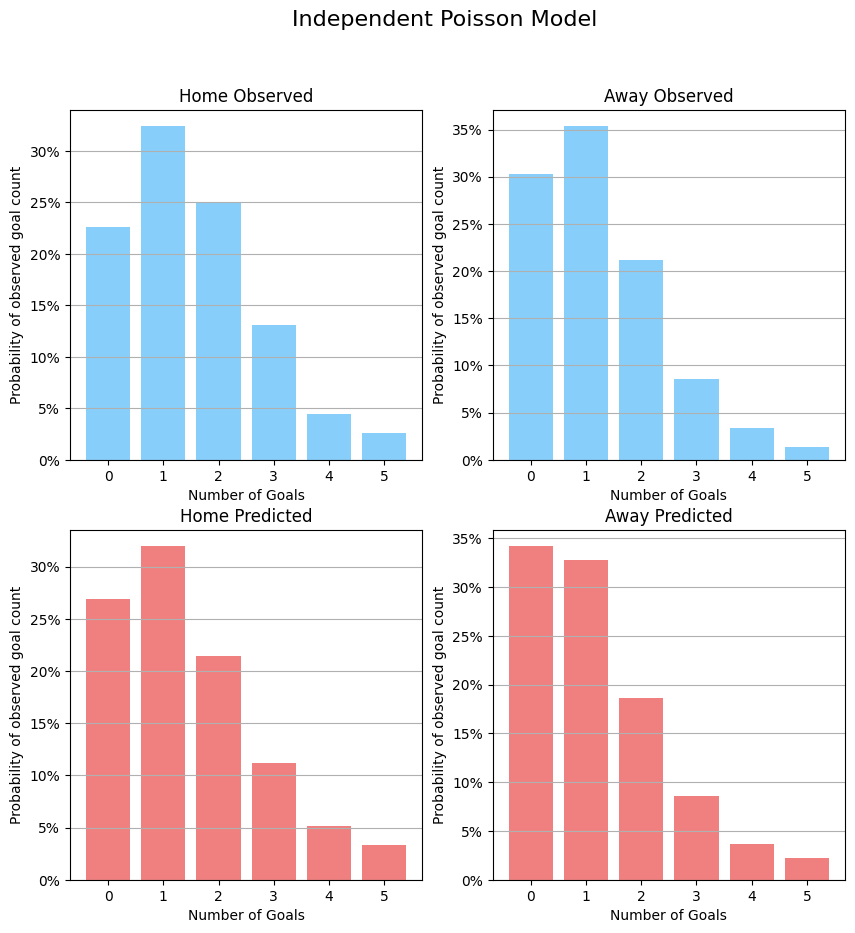

In [16]:
his_h, _ = np.histogram(train_data.home_score, [0, 1, 2, 3, 4, 5, 6])
his_a, _ = np.histogram(train_data.away_score, [0, 1, 2, 3, 4, 5, 6])
fig, (ax1, ax2) = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
fig.suptitle("Independent Poisson Model", fontsize=16)
ax1[0].bar(np.arange(len(his_h)), his_h / np.sum(his_h), color="lightskyblue")
ax1[0].set_title("Home Observed")
ax1[0].set_xlabel("Number of Goals")
ax1[0].set_ylabel("Probability of observed goal count")
ax1[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[0].grid(axis="y")

ax2[0].bar(
    np.arange(len(home_cum_hist)),
    home_cum_hist / np.sum(home_cum_hist),
    color="lightcoral",
)
ax2[0].set_title("Home Predicted")
ax2[0].set_xlabel("Number of Goals")
ax2[0].set_ylabel("Probability of observed goal count")
ax2[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[0].grid(axis="y")

ax1[1].bar(np.arange(len(his_a)), his_a / np.sum(his_a), color="lightskyblue")
ax1[1].set_title("Away Observed")
ax1[1].set_xlabel("Number of Goals")
ax1[1].set_ylabel("Probability of observed goal count")
ax1[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[1].grid(axis="y")

ax2[1].bar(
    np.arange(len(away_cum_hist)),
    away_cum_hist / np.sum(away_cum_hist),
    color="lightcoral",
)
ax2[1].set_title("Away Predicted")
ax2[1].set_xlabel("Number of Goals")
ax2[1].set_ylabel("Probability of observed goal count")
ax2[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[1].grid(axis="y")

In [17]:
print("observed")
print(np.mean(train_data.home_score))
print(np.mean(train_data.away_score))

observed
1.5348569549490299
1.2387372574810918


In [18]:
print(np.sum([x * idx for idx, x in enumerate(home_cum_hist)]) / np.sum(home_cum_hist))
print(np.sum([x * idx for idx, x in enumerate(away_cum_hist)]) / np.sum(away_cum_hist))

1.4565552252912004
1.215605035394945


In [19]:
res_table_p = np.array([sum(x) for x in zip(*all_probs)])
res_table_p.shape
res_table_p = res_table_p / test_data_orig_size

res_table_p = res_table_p[:5, :5]

Text(0.5, 23.52222222222222, 'Away Goals')

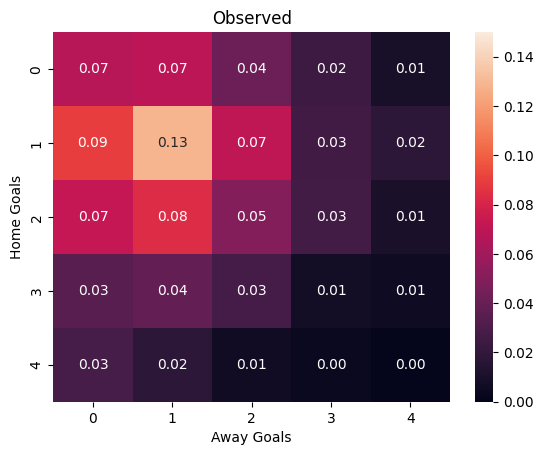

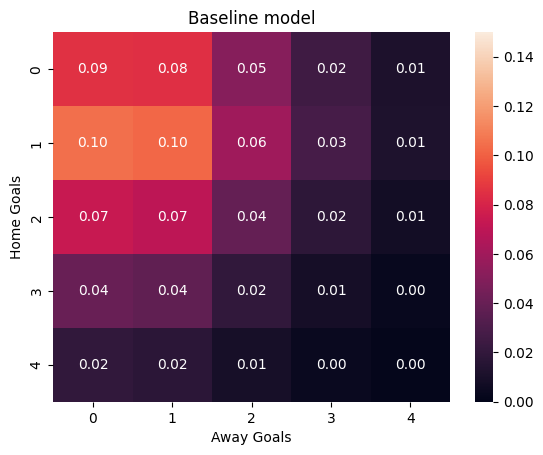

In [20]:
# actual
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_a = np.array([np.zeros(max_goals) for _ in range(max_goals)])
for h, a in zip(actual_home, actual_away):
    res_table_a[int(h)][int(a)] += 1
res_table_a = res_table_a / test_data_orig_size
res_table_a = res_table_a[:5, :5]

# predicted
# max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
# res_table_p = np.array([np.zeros(max_goals) for _ in range(max_goals)])

# game_quotes = []
# for game_idx in range(len(predictions_home)):
#     home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6,7])
#     away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6,7])
#     if home_hist.shape[0] < max_goals:
#         home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
#     if away_hist.shape[0] < max_goals:
#         away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

#     home_hist = home_hist / 1000
#     away_hist = away_hist / 1000
#     probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
#     probs = probs
#     res_table_p += probs

# res_table_p = res_table_p / test_data_orig_size


fig, axes = plt.subplots(1, 1)
# fig.suptitle("Independent Poisson Model")
sb.heatmap(ax=axes, data=res_table_a, annot=True, fmt=".2f", vmin=0, vmax=0.15)
axes.set_title("Observed")
axes.set_ylabel("Home Goals")
axes.set_xlabel("Away Goals")

fig, axes = plt.subplots(1, 1)
# fig.suptitle("Independent Poisson Model")
sb.heatmap(ax=axes, data=res_table_p, annot=True, fmt=".2f", vmin=0, vmax=0.15)
axes.set_title("Baseline model")
axes.set_ylabel("Home Goals")
axes.set_xlabel("Away Goals")

In [21]:
print(np.tril(res_table_a).sum() - np.trace(res_table_a))
print(np.trace(res_table_a))
print(np.triu(res_table_a).sum() - np.trace(res_table_a))

0.40194174757281564
0.25501618122977343
0.30226537216828475


In [22]:
print(np.tril(res_table_p).sum() - np.trace(res_table_p))
print(np.trace(res_table_p))
print(np.triu(res_table_p).sum() - np.trace(res_table_p))

0.39426326990291266
0.23682086407767017
0.29973761877022637


In [23]:
# max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
# res_table = np.array([np.zeros(max_goals) for _ in range(max_goals)])

# game_quotes = []
# for game_idx in range(len(predictions_home)):
#     home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6,7])
#     away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6,7])
#     if home_hist.shape[0] < max_goals:
#         home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
#     if away_hist.shape[0] < max_goals:
#         away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

#     home_hist = home_hist / 1000
#     away_hist = away_hist / 1000
#     probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
#     probs = probs
#     res_table += probs


# for x in range(len(res_table)):
#     for y in range(len(res_table[x])):
#         if x == y:
#             res_table[x][y] *= 1.2
#         else:
#             res_table[x][y] *= 0.95

# res_table = res_table / test_data_orig_size
# print(sum(sum(res_table)))
# sb.heatmap(res_table, annot=True)

In [24]:
df_cross

,actual,pred,pred_val,bookie,bookie_val
0,1,0,0.595583,2,37.290950
1,0,0,0.395513,0,62.975779
2,0,0,0.694333,2,50.000000
3,0,0,0.764977,0,81.810744
4,2,0,0.381639,0,52.927174
...,...,...,...,...,...
1540,2,2,0.798119,2,62.263129
1541,0,0,0.606071,0,83.160083
1542,2,2,0.444905,2,65.430464
1543,1,0,0.416371,2,54.500255


In [25]:
# ece
data_length = df_cross.shape[0]

# acc_model = np.sum(df_cross['actual'] == df_cross['pred']) / data_length
# acc_bookie = np.sum(df_cross['bookie'] == df_cross['actual']) / data_length

# print("Accuracy Model: ", acc_model)
# print("Accuracy Bookie: ", acc_bookie)

# conf_model = np.sum(df_cross['pred_val']) / data_length
# conf_bookie = np.sum(df_cross['bookie_val']/100) / data_length

# print("Confidence Model: ", conf_model)
# print("Confidence Bookie: ", conf_bookie)

# ece_model = np.mean(np.absolute(acc_model - conf_model))
# ece_bookie = np.mean(np.absolute(acc_bookie - conf_bookie))

# print(f"Model ECE: {ece_model}")
# print(f"Bookie ECE: {ece_bookie}")
acc_home = (
    df_cross.loc[(df_cross["bookie"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["bookie"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["bookie"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["bookie"] == 0)].bookie_val / 100)
conf_draw = np.mean(df_cross.loc[(df_cross["bookie"] == 1)].bookie_val / 100)
conf_away = np.mean(df_cross.loc[(df_cross["bookie"] == 2)].bookie_val / 100)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)


acc_home = (
    df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)

0.2601783491155203
nan
0.06721056586652263
0.27535772468699615
-0.3379652218999275
0.10930887689969615


In [26]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1004
# won: 467
# lost: 537
# money:  6749.102471962487

bets: 856
won: 439
lost: 417
money:  4871.599999999999


In [27]:
bet_threshold = 60
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) >= bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) >= bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) >= bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 381
# won: 319
# lost: 62
# money:  2066.035947551149

bets: 506
won: 400
lost: 106
money:  2454.4000000000015


In [28]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold or (float(pred_h) * 100) >= 60:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold or (float(pred_d) * 100) >= 60:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold or (float(pred_a) * 100) >= 60:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1206
# won: 640
# lost: 566
# money:  7222.5381890291965

bets: 1053
won: 596
lost: 457
money:  5047.000000000002


# Inflated Diagonal

In [29]:
print(np.trace(res_table_a) / np.trace(res_table_p))
print(np.trace(res_table_a) / (np.trace(res_table_p) * (np.trace(res_table_a) / np.trace(res_table_p))))


print((np.tril(res_table_a).sum() - np.trace(res_table_a) + np.triu(res_table_a).sum() - np.trace(res_table_a)) / 
      ((np.tril(res_table_p).sum() - np.trace(res_table_p) + np.triu(res_table_p).sum() - np.trace(res_table_p)) * 
       (np.tril(res_table_a).sum() - np.trace(res_table_a) + np.triu(res_table_a).sum() - np.trace(res_table_a)) / 
      ((np.tril(res_table_p).sum() - np.trace(res_table_p) + np.triu(res_table_p).sum() - np.trace(res_table_p)))))

1.0768315630591387
1.0
1.0


In [30]:
mult_diagonal = (np.trace(res_table_a) / np.trace(res_table_p))
mult_rest =  (np.tril(res_table_a).sum() - np.trace(res_table_a) + np.triu(res_table_a).sum() - np.trace(res_table_a)) / ((np.tril(res_table_p).sum() - np.trace(res_table_p) + np.triu(res_table_p).sum() - np.trace(res_table_p)))

In [31]:
home_std = np.std(predictions_home, axis=1)
away_std = np.std(predictions_away, axis=1)
print(f"Home std: {home_std.mean()}, Away std: {away_std.mean()}, Overall std: {(home_std.mean() + away_std.mean()) / 2}")

Home std: 1.2020949640570553, Away std: 1.0890947749570274, Overall std: 1.1455948695070415


In [32]:
all_probs = []
game_quotes = []
most_goals = {"home": [], "away": []}
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    if home_hist.shape[0] < max_goals:
        home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
    if away_hist.shape[0] < max_goals:
        away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))
    home_hist = home_hist / 1000
    away_hist = away_hist / 1000
    probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
    for x in range(len(probs)):
        for y in range(len(probs[x])):
            if x == y:
                probs[x][y] *= 1.3
            else:
                probs[x][y] *= 1 - 0.085
            # if x == y:
            #     probs[x][y] *= mult_diagonal
            # else:
            #     probs[x][y] *= mult_rest
    all_probs.append(np.array(probs))
    home = np.tril(probs).sum() - np.trace(probs)
    draw = np.trace(probs)
    away = np.triu(probs).sum() - np.trace(probs)
    game_quotes.append(f"{home}-{draw}-{away}")
    most_goals["home"].append(
        f"h: {np.argmax(home_hist)} - {round(np.max(home_hist)/10)}%"
    )
    most_goals["away"].append(
        f"a: {np.argmax(away_hist)} - {round(np.max(away_hist)/10)}%"
    )

df_res = pd.DataFrame(
    {
        "actual": act_res,
        "predicted": game_quotes,
        "prob goals home": most_goals["home"],
        "prob goals away": most_goals["away"],
    }
)
df_cross = pd.DataFrame(
    {
        "actual": [
            0
            if int(df_res.iloc[x]["actual"].split(":")[0])
            > int(df_res.iloc[x]["actual"].split(":")[1])
            else 1
            if int(df_res.iloc[x]["actual"].split(":")[0])
            == int(df_res.iloc[x]["actual"].split(":")[1])
            else 2
            for x in range(df_res.shape[0])
        ],
        "pred": [
            np.argmax([float(y) for y in df_res.iloc[x]["predicted"].split("-")])
            for x in range(df_res.shape[0])
        ],
        "pred_val": [
            np.max([float(y) for y in df_res.iloc[x]["predicted"].split("-")])
            for x in range(df_res.shape[0])
        ],
        "bookie": [
            np.argmax(
                [
                    test_data.iloc[x].bookie_home,
                    test_data.iloc[x].bookie_draw,
                    test_data.iloc[x].bookie_away,
                ]
            )
            for x in range(test_data_orig_size)
        ],
        "bookie_val": [
            np.max(
                [
                    test_data.iloc[x].bookie_home,
                    test_data.iloc[x].bookie_draw,
                    test_data.iloc[x].bookie_away,
                ]
            )
            for x in range(test_data_orig_size)
        ],
    }
)

In [33]:
print("Verteilung:")
print(
    f"Anzahl Predicted Home: {df_cross[df_cross['pred'] == 0].shape[0]} ({round(df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Home: {round(df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Draw: {df_cross[df_cross['pred'] == 1].shape[0]} ({round(df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Draw: {round(df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Away: {df_cross[df_cross['pred'] == 2].shape[0]} ({round(df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Away: {round(df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    "---------------------------------------------------------------------------------"
)
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_cross.shape[0]):
    if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
        if df_cross.iloc[x]["pred"] == 0:
            if df_cross.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_cross.iloc[x]["pred"] == 1:
            if df_cross.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_cross.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_cross.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_cross.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_cross.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_cross.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_cross[df_cross['pred'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(f"Home Pred. aber Draw --> {home_pred['act_draw']}")
print(f"Home Pred. aber Away --> {home_pred['act_away']}")
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_cross[df_cross['pred'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(f"Draw Pred. aber Home --> {draw_pred['act_home']}")
print(f"Draw Pred. aber Away --> {draw_pred['act_away']}")
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_cross[df_cross['pred'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(f"Away Pred. aber Home --> {away_pred['act_home']}")
print(f"Away Pred. aber Draw --> {away_pred['act_draw']}")

print(
    "---------------------------------------------------------------------------------"
)
print(f"Precision: ")
print(f"Home --> {home_right / (df_cross[df_cross['pred'] == 0].shape[0])}")
print(f"Draw --> {draw_right / (df_cross[df_cross['pred'] == 1].shape[0])}")
print(f"Away --> {away_right / (df_cross[df_cross['pred'] == 2].shape[0])}")
print(f"All mac --> {((home_right / (df_cross[df_cross['pred'] == 0].shape[0])) + (draw_right / (df_cross[df_cross['pred'] == 1].shape[0])) + (away_right / (df_cross[df_cross['pred'] == 2].shape[0]))) / 3}")
print(f"All mic --> {((home_right / (df_cross[df_cross['pred'] == 0].shape[0])) * (df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0]) + (draw_right / (df_cross[df_cross['pred'] == 1].shape[0]))  * (df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0]) + (away_right / (df_cross[df_cross['pred'] == 2].shape[0])) * (df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0]))}")

print(
    "---------------------------------------------------------------------------------"
)
print(f"Recall: ")
print(f"Home --> {home_right / (df_cross[df_cross['actual'] == 0].shape[0])}")
print(f"Draw --> {draw_right / (df_cross[df_cross['actual'] == 1].shape[0])}")
print(f"Away --> {away_right / (df_cross[df_cross['actual'] == 2].shape[0])}")
print(f"All mac --> {((home_right / (df_cross[df_cross['actual'] == 0].shape[0])) + (draw_right / (df_cross[df_cross['actual'] == 1].shape[0])) + (away_right / (df_cross[df_cross['actual'] == 2].shape[0]))) / 3}")
print(f"All mic --> {((home_right / (df_cross[df_cross['actual'] == 0].shape[0])) * (df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0]) + (draw_right / (df_cross[df_cross['actual'] == 1].shape[0]))  * (df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0]) + (away_right / (df_cross[df_cross['actual'] == 2].shape[0])) * (df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0]))}")


Verteilung:
Anzahl Predicted Home: 787 (50.94%) | Verteilung Tatsächlich Home: 42.78%
Anzahl Predicted Draw: 299 (19.35%) | Verteilung Tatsächlich Draw: 25.5%
Anzahl Predicted Away: 459 (29.71%) | Verteilung Tatsächlich Away: 31.72%
---------------------------------------------------------------------------------
Prediction:
Anzahl Korrekt: 879 (56.89%), Anzahl Falsch: 666 (43.11%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 486 (61.75%), Anzahl Home Falsch: 301
Home Pred. aber Draw --> 169
Home Pred. aber Away --> 132
Anzahl Draw Korrekt: 118 (39.46%), Anzahl Draw Falsch: 181
Draw Pred. aber Home --> 98
Draw Pred. aber Away --> 83
Anzahl Away Korrekt: 275 (59.91%), Anzahl Away Falsch: 184
Away Pred. aber Home --> 77
Away Pred. aber Draw --> 107
---------------------------------------------------------------------------------
Precision: 
Home --> 0.6175349428208387
Draw --> 0.39464882943143814
Away --> 0.599128540305011
All mac

In [34]:
df_cross.shape[0]

1545

In [35]:
pred_difficulty = test_data[["home_score", "away_score", "bookie_home", "bookie_draw", "bookie_away"]].copy()
pred_difficulty = pred_difficulty.iloc[:df_cross.shape[0]]
conditions = [((pred_difficulty["bookie_home"] >= pred_difficulty["bookie_draw"] + pred_difficulty["bookie_away"]) & (pred_difficulty["home_score"] > pred_difficulty["away_score"])),
              ((pred_difficulty["bookie_draw"] >= pred_difficulty["bookie_home"] + pred_difficulty["bookie_away"]) & (pred_difficulty["home_score"] == pred_difficulty["away_score"])),
              ((pred_difficulty["bookie_away"] >= pred_difficulty["bookie_draw"] + pred_difficulty["bookie_home"]) & (pred_difficulty["home_score"] < pred_difficulty["away_score"])),
              ((pred_difficulty["bookie_home"] >= pred_difficulty["bookie_draw"] + pred_difficulty["bookie_away"]) & (pred_difficulty["home_score"] <= pred_difficulty["away_score"])),
              ((pred_difficulty["bookie_draw"] >= pred_difficulty["bookie_home"] + pred_difficulty["bookie_away"]) & (pred_difficulty["home_score"] != pred_difficulty["away_score"])),
              ((pred_difficulty["bookie_away"] >= pred_difficulty["bookie_draw"] + pred_difficulty["bookie_home"]) & (pred_difficulty["home_score"] >= pred_difficulty["away_score"])),
              (((pred_difficulty["bookie_home"] < pred_difficulty["bookie_draw"] + pred_difficulty["bookie_away"])) & 
               ((pred_difficulty["bookie_draw"] < pred_difficulty["bookie_home"] + pred_difficulty["bookie_away"])) & 
               ((pred_difficulty["bookie_away"] < pred_difficulty["bookie_home"] + pred_difficulty["bookie_away"])))
               ]
values = ["easy", "easy", "easy", "upset", "upset", "upset", "hard"]

pred_difficulty["difficulty"] = np.select(conditions, values)
print(pred_difficulty["difficulty"].value_counts())

df_cross["class"] = pred_difficulty["difficulty"]
df_easy = df_cross[df_cross["class"] == "easy"]
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_easy.shape[0]):
    if df_easy.iloc[x]["actual"] != df_easy.iloc[x]["pred"]:
        if df_easy.iloc[x]["pred"] == 0:
            if df_easy.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_easy.iloc[x]["pred"] == 1:
            if df_easy.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_easy.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_easy.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_easy.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction Easy:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_easy.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_easy.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_easy[df_easy['pred'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_easy[df_easy['pred'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_easy[df_easy['pred'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(
    "---------------------------------------------------------------------------------\n"
    "---------------------------------------------------------------------------------"
)

df_hard = df_cross[df_cross["class"] == "hard"]
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_hard.shape[0]):
    if df_hard.iloc[x]["actual"] != df_hard.iloc[x]["pred"]:
        if df_hard.iloc[x]["pred"] == 0:
            if df_hard.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_hard.iloc[x]["pred"] == 1:
            if df_hard.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_hard.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_hard.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_hard.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1
home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction Hard:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_hard.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_hard.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_hard[df_hard['pred'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_hard[df_hard['pred'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_hard[df_hard['pred'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(
    "---------------------------------------------------------------------------------\n"
    "---------------------------------------------------------------------------------"
)

df_upset = df_cross[df_cross["class"] == "upset"]
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_upset.shape[0]):
    if df_upset.iloc[x]["actual"] != df_upset.iloc[x]["pred"]:
        if df_upset.iloc[x]["pred"] == 0:
            if df_upset.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_upset.iloc[x]["pred"] == 1:
            if df_upset.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_upset.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_upset.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_upset.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1
home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction Upset:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_upset.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_upset.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_upset[df_upset['pred'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_upset[df_upset['pred'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_upset[df_upset['pred'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)

hard     793
easy     475
upset    277
Name: difficulty, dtype: int64
Prediction Easy:
Anzahl Korrekt: 400 (84.21%), Anzahl Falsch: 75 (15.79%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 293 (97.67%), Anzahl Home Falsch: 7
Anzahl Draw Korrekt: 0 (0.0%), Anzahl Draw Falsch: 55
Anzahl Away Korrekt: 107 (89.17%), Anzahl Away Falsch: 13
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Prediction Hard:
Anzahl Korrekt: 409 (51.58%), Anzahl Falsch: 384 (48.42%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 178 (53.94%), Anzahl Home Falsch: 152
Anzahl Draw Korrekt: 81 (42.41%), Anzahl Draw Falsch: 110
Anzahl Away Korrekt: 150 (55.15%), Anzahl Away Falsch: 122
---------------------------------------------------------------------------------
--------------------------

In [36]:
h = np.array([np.array(xi, dtype=float) for xi in df_res.predicted.str.split("-")])[:,0]
d = np.array([np.array(xi, dtype=float) for xi in df_res.predicted.str.split("-")])[:,1]
a = np.array([np.array(xi, dtype=float) for xi in df_res.predicted.str.split("-")])[:,2]

print(np.mean(h))
print(np.mean(d))
print(np.mean(a))

0.39451007635922336
0.30814431106796114
0.2974728676893204


In [37]:
home_histograms, away_histograms = [], []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    home_histograms.append(home_hist)
    away_histograms.append(away_hist)

home_cum_hist = np.sum(home_histograms, axis=0)
away_cum_hist = np.sum(away_histograms, axis=0)

Observed: Home: 1.5348569549490299, away: 1.2387372574810918
Predicted: Home:1.4565552252912004, Away: 1.215605035394945


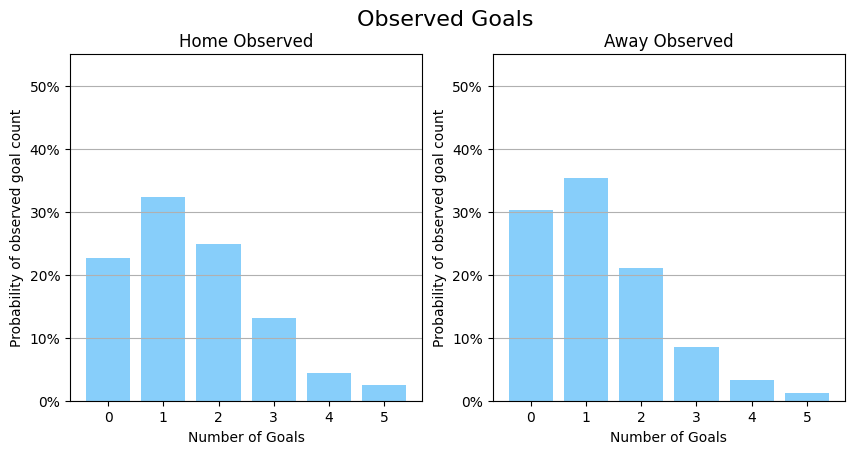

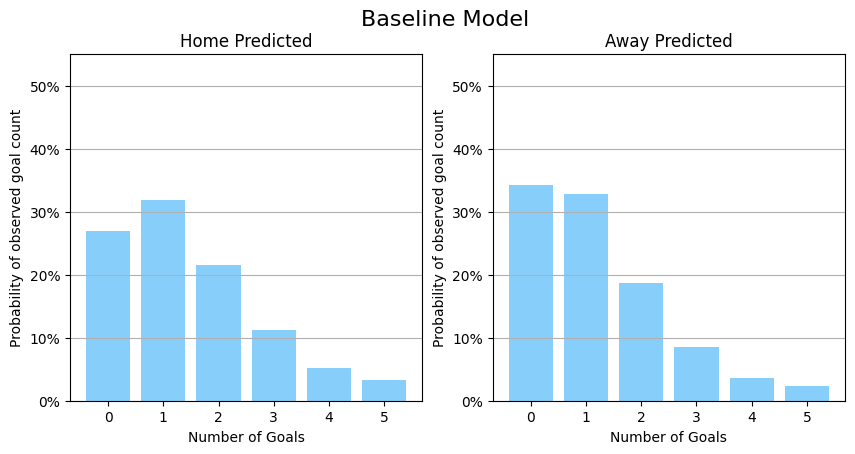

In [38]:
home_histograms, away_histograms = [], []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        np.array(predictions_home[game_idx], dtype=int), [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        np.array(predictions_away[game_idx], dtype=int), [0, 1, 2, 3, 4, 5, 6]
    )
    home_histograms.append(home_hist)
    away_histograms.append(away_hist)

home_cum_hist = np.sum(home_histograms, axis=0)
away_cum_hist = np.sum(away_histograms, axis=0)

if True: # draw histograms
    his_h, _ = np.histogram(train_data.home_score, [0, 1, 2, 3, 4, 5, 6])
    his_a, _ = np.histogram(train_data.away_score, [0, 1, 2, 3, 4, 5, 6])
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 4.5)
    fig.suptitle("Observed Goals", fontsize=16)
    ax1.bar(np.arange(len(his_h)), his_h / np.sum(his_h), color="lightskyblue")
    ax1.set_title("Home Observed")
    ax1.set_xlabel("Number of Goals")
    ax1.set_ylabel("Probability of observed goal count")
    ax1.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax1.grid(axis="y")
    ax2.bar(np.arange(len(his_a)), his_a / np.sum(his_a), color="lightskyblue")
    ax2.set_title("Away Observed")
    ax2.set_xlabel("Number of Goals")
    ax2.set_ylabel("Probability of observed goal count")
    ax2.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax2.grid(axis="y")
    ax2.set_ylim([0,0.55])
    ax1.set_ylim([0,0.55])


    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 4.5)
    fig.suptitle("Baseline Model", fontsize=16)
    ax1.bar(
        np.arange(len(home_cum_hist)),
        home_cum_hist / np.sum(home_cum_hist),
        color="lightskyblue",
    )
    ax1.set_title("Home Predicted")
    ax1.set_xlabel("Number of Goals")
    ax1.set_ylabel("Probability of observed goal count")
    ax1.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax1.grid(axis="y")
    ax2.bar(
        np.arange(len(away_cum_hist)),
        away_cum_hist / np.sum(away_cum_hist),
        color="lightskyblue",
    )
    ax2.set_title("Away Predicted")
    ax2.set_xlabel("Number of Goals")
    ax2.set_ylabel("Probability of observed goal count")
    ax2.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax2.grid(axis="y")
    ax2.set_ylim([0,0.55])
    ax1.set_ylim([0,0.55])


print(f"Observed: Home: {np.mean(train_data.home_score)}, away: {np.mean(train_data.away_score)}")
print(f"Predicted: Home:{np.sum([x * idx for idx, x in enumerate(home_cum_hist)]) / np.sum(home_cum_hist)}, Away: {np.sum([x * idx for idx, x in enumerate(away_cum_hist)]) / np.sum(away_cum_hist)}")

In [39]:
print(np.sum([x * idx for idx, x in enumerate(home_cum_hist)]) / np.sum(home_cum_hist))
print(np.sum([x * idx for idx, x in enumerate(away_cum_hist)]) / np.sum(away_cum_hist))

1.4565552252912004
1.215605035394945


In [40]:
res_table_p = np.array([sum(x) for x in zip(*all_probs)])
res_table_p.shape
res_table_p = res_table_p / test_data_orig_size

res_table_p = res_table_p[:5, :5]

Text(0.5, 23.52222222222222, 'Away Goals')

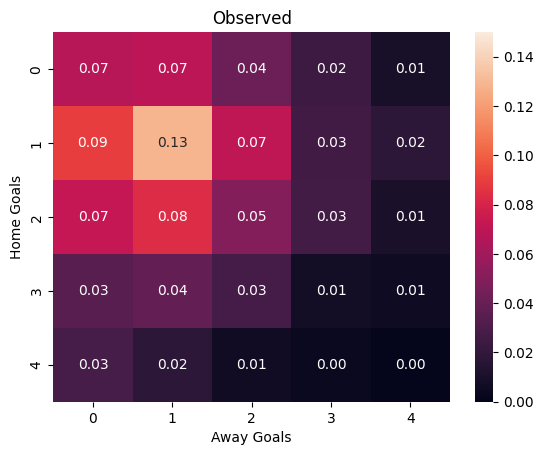

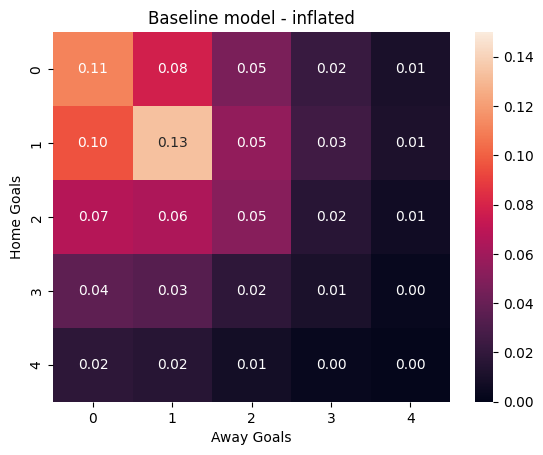

In [41]:
# actual
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_a = np.array([np.zeros(max_goals) for _ in range(max_goals)])
for h, a in zip(actual_home, actual_away):
    res_table_a[int(h)][int(a)] += 1
res_table_a = res_table_a / test_data_orig_size
res_table_a = res_table_a[:5, :5]

# predicted
# max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
# res_table_p = np.array([np.zeros(max_goals) for _ in range(max_goals)])

# game_quotes = []
# for game_idx in range(len(predictions_home)):
#     home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6,7])
#     away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6,7])
#     if home_hist.shape[0] < max_goals:
#         home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
#     if away_hist.shape[0] < max_goals:
#         away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

#     home_hist = home_hist / 1000
#     away_hist = away_hist / 1000
#     probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
#     probs = probs
#     res_table_p += probs

# res_table_p = res_table_p / test_data_orig_size


fig, axes = plt.subplots(1, 1)
# fig.suptitle("Independent Poisson Model")
sb.heatmap(ax=axes, data=res_table_a, annot=True, fmt=".2f", vmin=0, vmax=0.15)
axes.set_title("Observed")
axes.set_ylabel("Home Goals")
axes.set_xlabel("Away Goals")

fig, axes = plt.subplots(1, 1)
# fig.suptitle("Independent Poisson Model")
sb.heatmap(ax=axes, data=res_table_p, annot=True, fmt=".2f", vmin=0, vmax=0.15)
axes.set_title("Baseline model - inflated")
axes.set_ylabel("Home Goals")
axes.set_xlabel("Away Goals")

In [42]:
print(np.tril(res_table_p).sum() - np.trace(res_table_p))
print(np.trace(res_table_p))
print(np.triu(res_table_p).sum() - np.trace(res_table_p))

print(
    np.sum(
        [
            np.tril(res_table_p).sum() - np.trace(res_table_p),
            np.trace(res_table_p),
            np.triu(res_table_p).sum() - np.trace(res_table_p),
        ]
    )
)

0.360750891961165
0.3078671233009706
0.27425992117475734
0.9428779364368929


In [43]:
# ece
data_length = df_cross.shape[0]

# acc_model = np.sum(df_cross['actual'] == df_cross['pred']) / data_length
# acc_bookie = np.sum(df_cross['bookie'] == df_cross['actual']) / data_length

# print("Accuracy Model: ", acc_model)
# print("Accuracy Bookie: ", acc_bookie)

# conf_model = np.sum(df_cross['pred_val']) / data_length
# conf_bookie = np.sum(df_cross['bookie_val']/100) / data_length

# print("Confidence Model: ", conf_model)
# print("Confidence Bookie: ", conf_bookie)

# ece_model = np.mean(np.absolute(acc_model - conf_model))
# ece_bookie = np.mean(np.absolute(acc_bookie - conf_bookie))

# print(f"Model ECE: {ece_model}")
# print(f"Bookie ECE: {ece_bookie}")
acc_home = (
    df_cross.loc[(df_cross["bookie"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["bookie"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["bookie"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["bookie"] == 0)].bookie_val / 100)
conf_draw = np.mean(df_cross.loc[(df_cross["bookie"] == 1)].bookie_val / 100)
conf_away = np.mean(df_cross.loc[(df_cross["bookie"] == 2)].bookie_val / 100)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)


acc_home = (
    df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)

0.2601783491155203
nan
0.06721056586652263
0.1959513830621752
-0.12602755769145885
0.04223341786781376


In [44]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1004
# won: 467
# lost: 537
# money:  6749.102471962487

bets: 1039
won: 456
lost: 583
money:  5226.5


In [45]:
bet_threshold = 60
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) >= bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) >= bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) >= bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 381
# won: 319
# lost: 62
# money:  2066.035947551149

bets: 348
won: 292
lost: 56
money:  1678.5999999999997


In [46]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold or (float(pred_h) * 100) >= 60:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold or (float(pred_d) * 100) >= 60:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold or (float(pred_a) * 100) >= 60:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1206
# won: 640
# lost: 566
# money:  7222.5381890291965

bets: 1208
won: 603
lost: 605
money:  5538.500000000002


In [47]:
df_cross

,actual,pred,pred_val,bookie,bookie_val,class
0,1,0,0.544958,2,37.290950,hard
1,0,1,0.400035,0,62.975779,easy
2,0,0,0.635315,2,50.000000,upset
3,0,0,0.699954,0,81.810744,easy
4,2,1,0.363945,0,52.927174,upset
...,...,...,...,...,...,...
1540,2,2,0.730279,2,62.263129,easy
1541,0,0,0.554555,0,83.160083,easy
1542,2,2,0.407088,2,65.430464,easy
1543,1,1,0.390333,2,54.500255,upset
